In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.ticker import *
from matplotlib import colorbar
import acoustics
from scipy.optimize import curve_fit
from scipy.integrate import simps, odeint
from sklearn.metrics import r2_score
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math

# Read the frequency response

# Bubblecurtain class

In [2]:
class bubblecurtain:
    def __init__(self,path, r, smin, smax, airflow , mu=-6.7, sigma=0.67):
        self.path = path
        self.r = r
        self.mu=mu
        self.airflow=airflow
        self.sigma=sigma
        self.smin = smin
        self.smax = smax
        self.force_complex = pd.read_csv(os.path.join(self.path, 'INPUT', 'force transform complex.dat')
                                        , delim_whitespace=True, header=None, names=['f', 'Re', 'Im'])
        self.force_complex['F'] = self.force_complex.Re + self.force_complex.Im*1j
        self.force_complex.drop(['Re', 'Im'], axis=1, inplace=True)
 
        self.mesh_z_fluid = pd.read_csv(os.path.join(self.path, 'RESULTS', 'MESH', 'RECEIVER_FLUID_MESH.dat')
                                       ,delim_whitespace=True, header=None, names='z').round(2)
        
        self.mesh_z_source = pd.read_csv(os.path.join('C:\\Users\ipj\OneDrive - Van Oord\sim_backup\PROPSIM1',
                                                      'RESULTS', 'IMMERSED RESPONSE', 'VELO FLUID RADIAL.dat')
                                        , delim_whitespace=True, header=None, names='z', usecols=[0]).z.unique()
        self.mesh_z_source = self.mesh_z_source - self.mesh_z_source.min()
        self.df=self.force_complex.f[0]
        
        
        with open(os.path.join(self.path, 'INPUT DATA VALUES.dat')) as datfile:
            vals = datfile.read().split()
            self.zmax = round(float(vals[9]) - float(vals[8]),1)
        
    
    def mesh_r_fluid(self):
        
        with open(os.path.join(self.path, 'INPUT SILENCE PRO.dat')) as textfile:
            textlist = textfile.read().split()
            r0 = int(textlist[3])
            dr = int(textlist[5])
            nr = int(textlist[7])
            return np.linspace(r0, r0+dr*(nr-1), nr)
        
        
        
        
    def frequency_domain(self, quantity='Pressure'):
        folder = os.path.join(self.path, 'RESULTS', 'OUTPUT MODULE SILENCE PRO', 'Freq_Response', 'FLUID', quantity)
        files = os.listdir(folder)
        
        matrix = pd.DataFrame()
        
        i = 1
        for file in files:
            df = pd.read_csv(os.path.join(folder, file), delim_whitespace=True, header=None, names=['Re', 'Im'])
            z_coord = self.mesh_z_fluid
            r_coord = self.mesh_r_fluid()

            df['z'] = pd.concat([z_coord]*int(len(df)/len(z_coord)), ignore_index=True)
            df['r'] = np.repeat(r_coord, len(z_coord))
            df['f'] = i*self.force_complex.f[0]
            

            df['cplx'] = df.Re + df.Im*1j
            

            df = df.loc[df.r == self.r]
            

            matrix = matrix.append(df)
            i+=1
        #End of loop
        matrix.drop(['Re', 'Im', 'r'], axis=1, inplace=True)
        
        matrix.reset_index(inplace=True, drop=True)
    
        
        return matrix.f.values, matrix.pivot(index='z', columns='f', values='cplx').values
        
    
    
    
    def transmission_coeff(self, thickness):
        c = 1500
        c_m = 226 #Reference Tsouvalas
        omega = self.force_complex.f.values*2*np.pi
        k = omega/c
        k_m = omega/c_m
        s = thickness
   
        return np.abs((np.exp(1j*k*s))/(np.cos(k_m*s)+(1j/2)*(c/c_m + c_m/c)*np.sin(k_m*s)))**2
    
    def reflection_coeff(self, thickness):
        c = 1500
        c_m = 226 #Reference Tsouvalas
        omega = self.force_complex.f.values*2*np.pi
        k = omega/c
        k_m = omega/c_m
        s = thickness
        return np.abs((1/2)*(1j*(c_m/c - c/c_m)*np.sin(k_m*s))/(np.cos(k_m*s)+(1j/2) * (c/c_m + c_m/c) * np.sin(k_m*s)))**2
        
    def curtain_thickness(self):
        z = self.mesh_z_source
        return ((self.smin-self.smax)/z.max())*z+self.smax
    
    def plot_coeff_vs_z(self):
        A = self.BBC()
        
        fig ,ax = plt.subplots(1, figsize=(5,5))
        
        for i in [0, A.shape[1]//2, A.shape[1]-1]:
            	ax.plot(A[:,i], self.mesh_z_source, label = '{} Hz'.format(round((i+1)*self.force_complex.f[0],3)))
                
        ax.set_title('Transmission coefficient vs. Depth')
        ax.set_xlabel('\u03B6 [-]')
        ax.set_ylabel('z [m]')
        ax.invert_yaxis()
        ax.set_ylim(0, self.mesh_z_source.max())
        ax.set_xlim(0, 1.2)
        ax.legend()
        
    def plot_coeff_vs_f(self):
        A = self.BBC()
        
        fig ,ax = plt.subplots(1, figsize=(5,5))
        
        for i in [0, A.shape[0]//2, A.shape[0]-1]:
            	ax.plot(self.force_complex.f, A[i,:], label = '{} Hz'.format(round((i+1)*self.force_complex.f[0],3)))
        
        ax.set_xlim(self.force_complex.f.min(), self.force_complex.f.max())
        ax.set_ylim(0, 1)
        ax.set_title('Transmission coefficient vs. Depth')
        ax.set_ylabel('\u03B6 [-]', rotation=0)
        ax.set_xlabel('f [Hz]')
        ax.legend()
    
    def plot_coeff_2D(self):
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
        im = ax.imshow(self.BBC(), aspect='auto', cmap='jet', extent=[0, self.force_complex.f.max(), 
                                                                      self.mesh_z_source.max(), self.mesh_z_source.min() ])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.1)
        cbar = fig.colorbar(im, ax=ax, cax=cax, orientation='vertical')
        cbar.set_label('T [-]', rotation=0)
     
        ax.set_xlabel('f [Hz]')
        ax.set_ylabel('z [m]')
        ax.set_title('Coefficient matrix')
  
        
        if bool(int(input('Savefig (1/0): '))):
            filename=input('Filename: ')
            fig.savefig('C:\\Users\ipj\OneDrive - Van Oord\Figs_backup\Full simulations\Dump\{}.png'.format(filename), dpi=300,
                       bbox_inches='tight')
        else:
            pass
    
    def BBC(self):
        BBC = []
        S = self.curtain_thickness()
        
        for s in S:
            BBC.append(self.transmission_coeff(s))
    
        return np.array(BBC)
    
    
    def format_data(self, quantity='PRESSURE'):
        
        source_path = os.path.join(self.path, 'RESULTS', 'FREQUENCY RESPONSE - ORIGINAL', 'FLUID', quantity)
        files = os.listdir(source_path)
        coords = pd.read_csv(os.path.join(self.path,
                                                      'RESULTS', 'IMMERSED RESPONSE', 'VELO FLUID RADIAL.dat')
                                        , delim_whitespace=True, header=None, names=['z', 'r'], usecols=[0,1])
        
        i=1
        
        savepath=os.path.join(self.path, 'RESULTS', 'FREQUENCY RESPONSE', 'FLUID', quantity)
        for file in files:
            #Format the frequencies at a certain r
            g = self.BBC()[:,i-1]
            filepath = os.path.join(source_path, file)
            df = pd.read_csv(filepath, delim_whitespace=True, header=None, names=['Re', 'Im'])
            df['z'] = coords['z']
            df['r'] = coords['r']
            df['f'] = i*self.df
            df.loc[df.r == self.r, ['Re', 'Im']] = df.loc[df.r == self.r, ['Re', 'Im']]*np.array([g,g]).transpose()
            i+=1
            
            df_to_save = df[['Re', 'Im']]
            df_to_save.to_csv(os.path.join(savepath,file), index=False, header=False, sep='\t')
           
        
    #Methods for bohne et al.
            
    def bubble_size_distribution(self):
        amin = 0.004
        amax = 0.013
        da = 0.00001

        a = np.arange(amin, amax+da, da)
        return a, (1/(a*self.sigma*np.sqrt(2*np.pi)))*np.exp(-(np.log(a)-self.mu)**2/(2*self.sigma**2))
    
    def mean_bubble_volume(self):
        a = self.bubble_size_distribution()[0]
        f = self.bubble_size_distribution()[1]
        
        y = (4/3)*np.pi*f*a**3
        
        return simps(y, x=a)
    
    def bubble_solver(self):
        #Unknown parameters, fit
        u_rel = 0.4
        lamb = 0.2
        gamba=1
        alpha = 0.16
        g = 9.81
        
        rho_g_surf = 1.225
        P_atm = 100000
        rho_w =1000
        #Airflow
        m0 = self.airflow
        
        #Nozzle properties
        d_n = .001 #Nozzle diameter
        del_y_n = 0.1 #Nozzle spacing
        
        
        
        
        #Depth vector
        z0 = 0
        T = 2#self.mesh_z_source.max()
        dz = 0.0001
        
        z = np.arange(5*dz, T+dz, dz)
        
        #Density
        def rho_g(z):

            rhog_z = (rho_g_surf/P_atm)*(rho_w*g*(T-z) + P_atm)
            
            return rhog_z
        
        
        def calc_b(ulzm, egm, rho_gz_i):
            b = m0 / egm * np.pi ** (-0.1e1 / 0.2e1) / lamb / rho_gz_i / (ulzm * (lamb ** 2 + 1) ** (-0.1e1 / 0.2e1) + u_rel)
            
            return b
        
       
        rho_g0 = rho_g(z[0])
        #Initial conditions
        egm0 = 0.95
        
        M0 = (4*del_y_n*m0**2)/(np.pi*rho_g0*d_n**2)
        
        
        ulzm0 = 0
        it_count = 0
        dulzm = 0.00001
        error = dulzm
        
        while True:
            it_count +=1
            b0 = calc_b(ulzm0, egm0, rho_g0)
            test = (np.sqrt(2)*np.sqrt(M0)*(2*lamb**2+1)**0.25)/(np.pi**0.25 *np.sqrt((np.sqrt(4*lamb**2+2)-2*egm0*lamb)*gamba*b0*rho_w))

            if test-error<= ulzm0 <= test+error:
                break

            else:
                ulzm0 += dulzm
                
            
        print('Calculation of initial conditions took {} iterations'.format(it_count))
        print('ulzm0 = {}\nb0 = {}\nrho_g0 = {}'.format(ulzm0, b0, rho_g0) )
        
        
        
        def dudz(q, z):
            
            ulzm = q[0]
            egm = q[1]
            
            
            pi = np.pi
            
            
            b1 = egm * rho_w * g * math.sqrt((lamb ** 2 + 1) * m0 ** 2 * P_atm ** 2 / (rho_w * g * (T - z) + P_atm) ** 2 / rho_g_surf ** 2 / egm ** 2 / (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2)
            b2 = 2 * alpha * rho_w * ulzm
            
            B = np.array([[b1], [b2]])
            
            dmdz1 = -rho_w * gamba * ulzm ** 2 * math.sqrt(2) * ((m0 ** 2 * P_atm ** 2 * (lamb ** 2 + 1) / (rho_w * g * (T - z) + P_atm) ** 2 / rho_g_surf ** 2 / egm ** 2 / (lamb + 0.1e1 / 0.2e1) / (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2) ** (-0.1e1 / 0.2e1) / egm * m0 ** 2 * P_atm ** 2 * (lamb ** 2 + 1) / (rho_w * g * (T - z) + P_atm) ** 3 / rho_g_surf ** 2 / (lamb + 0.1e1 / 0.2e1) / (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 * rho_w * g - (m0 ** 2 * P_atm ** 2 * (lamb ** 2 + 1) / (rho_w * g * (T - z) + P_atm) ** 2 / rho_g_surf ** 2 / egm ** 2 / (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 / lamb ** 2) ** (-0.1e1 / 0.2e1) * m0 ** 2 * P_atm ** 2 * (lamb ** 2 + 1) / (rho_w * g * (T - z) + P_atm) ** 3 / rho_g_surf ** 2 / egm ** 2 / (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 / lamb ** 2 * rho_w * g) / 2

            dmdz2 = -rho_w ** 2 * ((u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 * pi * rho_g_surf ** 2 * egm ** 2 * (rho_w * g * (T - z) + P_atm) ** 2 / m0 ** 2 / P_atm ** 2) ** (-0.3e1 / 0.2e1) * (-math.sqrt((u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 * pi * rho_g_surf ** 2 * egm ** 2 * (rho_w * g * (T - z) + P_atm) ** 2 / m0 ** 2 / P_atm ** 2) * m0 * P_atm * math.sqrt(lamb ** 2 + 1) + rho_g_surf * egm ** 2 * lamb * math.sqrt(math.pi) * (rho_w * g * (T - z) + P_atm) * (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm)) * ulzm * rho_g_surf * egm / lamb * (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) * pi / m0 ** 2 / P_atm ** 2 * g - rho_w * ((u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 * pi * rho_g_surf ** 2 * egm ** 2 * (rho_w * g * (T - z) + P_atm) ** 2 / m0 ** 2 / P_atm ** 2) ** (-0.1e1 / 0.2e1) * (((u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 * pi * rho_g_surf ** 2 * egm ** 2 * (rho_w * g * (T - z) + P_atm) ** 2 / m0 ** 2 / P_atm ** 2) ** (-0.1e1 / 0.2e1) / m0 / P_atm * math.sqrt(lamb ** 2 + 1) * (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 * pi * rho_g_surf ** 2 * egm ** 2 * (rho_w * g * (T - z) + P_atm) * rho_w * g - rho_g_surf * egm ** 2 * lamb * math.sqrt(math.pi) * rho_w * g * (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm)) * ulzm / rho_g_surf / egm / lamb / (rho_w * g * (T - z) + P_atm) / (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) - rho_w ** 2 * ((u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 * pi * rho_g_surf ** 2 * egm ** 2 * (rho_w * g * (T - z) + P_atm) ** 2 / m0 ** 2 / P_atm ** 2) ** (-0.1e1 / 0.2e1) * (-math.sqrt((u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 * pi * rho_g_surf ** 2 * egm ** 2 * (rho_w * g * (T - z) + P_atm) ** 2 / m0 ** 2 / P_atm ** 2) * m0 * P_atm * math.sqrt(lamb ** 2 + 1) + rho_g_surf * egm ** 2 * lamb * math.sqrt(math.pi) * (rho_w * g * (T - z) + P_atm) * (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm)) * ulzm / rho_g_surf / egm / lamb / (rho_w * g * (T - z) + P_atm) ** 2 / (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) * g

            DMDZ = np.array([[dmdz1], [dmdz2]])
            
            dmdu11 = -rho_w * gamba * ulzm * math.sqrt(2) * (math.sqrt(m0 ** 2 * P_atm ** 2 * (lamb ** 2 + 1) / egm ** 2 / rho_g_surf ** 2 / (lamb + 0.1e1 / 0.2e1) / (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 / (rho_w * g * (T - z) + P_atm) ** 2) * egm - math.sqrt(m0 ** 2 * P_atm ** 2 * (lamb ** 2 + 1) / egm ** 2 / rho_g_surf ** 2 / lamb ** 2 / (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 / (rho_w * g * (T - z) + P_atm) ** 2)) - rho_w * gamba * ulzm ** 2 * math.sqrt(2) * (-(m0 ** 2 * P_atm ** 2 * (lamb ** 2 + 1) / egm ** 2 / rho_g_surf ** 2 / (lamb + 0.1e1 / 0.2e1) / (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 / (rho_w * g * (T - z) + P_atm) ** 2) ** (-0.1e1 / 0.2e1) / egm * m0 ** 2 * P_atm ** 2 * (lamb ** 2 + 1) / rho_g_surf ** 2 / (lamb + 0.1e1 / 0.2e1) / (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 3 / (rho_w * g * (T - z) + P_atm) ** 2 + (m0 ** 2 * P_atm ** 2 * (lamb ** 2 + 1) / egm ** 2 / rho_g_surf ** 2 / lamb ** 2 / (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 / (rho_w * g * (T - z) + P_atm) ** 2) ** (-0.1e1 / 0.2e1) * m0 ** 2 * P_atm ** 2 * (lamb ** 2 + 1) / egm ** 2 / rho_g_surf ** 2 / lamb ** 2 / (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 3 / (rho_w * g * (T - z) + P_atm) ** 2) / 2

            dmdu12 = -rho_w * gamba * ulzm ** 2 * math.sqrt(2) * (-(m0 ** 2 * P_atm ** 2 * (lamb ** 2 + 1) / egm ** 2 / rho_g_surf ** 2 / (lamb + 0.1e1 / 0.2e1) / (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 / (rho_w * g * (T - z) + P_atm) ** 2) ** (-0.1e1 / 0.2e1) / egm ** 2 * m0 ** 2 * P_atm ** 2 * (lamb ** 2 + 1) / rho_g_surf ** 2 / (lamb + 0.1e1 / 0.2e1) / (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 / (rho_w * g * (T - z) + P_atm) ** 2 + math.sqrt(m0 ** 2 * P_atm ** 2 * (lamb ** 2 + 1) / egm ** 2 / rho_g_surf ** 2 / (lamb + 0.1e1 / 0.2e1) / (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 / (rho_w * g * (T - z) + P_atm) ** 2) + (m0 ** 2 * P_atm ** 2 * (lamb ** 2 + 1) / egm ** 2 / rho_g_surf ** 2 / lamb ** 2 / (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 / (rho_w * g * (T - z) + P_atm) ** 2) ** (-0.1e1 / 0.2e1) * m0 ** 2 * P_atm ** 2 * (lamb ** 2 + 1) / egm ** 3 / rho_g_surf ** 2 / lamb ** 2 / (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 / (rho_w * g * (T - z) + P_atm) ** 2) / 2

            dmdu21 = rho_w * (pi * egm ** 2 * rho_g_surf ** 2 * (rho_w * g * (T - z) + P_atm) ** 2 * (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 / m0 ** 2 / P_atm ** 2) ** (-0.3e1 / 0.2e1) * (-math.sqrt(pi * egm ** 2 * rho_g_surf ** 2 * (rho_w * g * (T - z) + P_atm) ** 2 * (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 / m0 ** 2 / P_atm ** 2) * m0 * P_atm * math.sqrt(lamb ** 2 + 1) + rho_g_surf * (rho_w * g * (T - z) + P_atm) * math.sqrt(math.pi) * lamb * (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) * egm ** 2) * ulzm * rho_g_surf * (rho_w * g * (T - z) + P_atm) / lamb * egm * pi / m0 ** 2 / P_atm ** 2 - rho_w * (pi * egm ** 2 * rho_g_surf ** 2 * (rho_w * g * (T - z) + P_atm) ** 2 * (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 / m0 ** 2 / P_atm ** 2) ** (-0.1e1 / 0.2e1) * (-(pi * egm ** 2 * rho_g_surf ** 2 * (rho_w * g * (T - z) + P_atm) ** 2 * (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 / m0 ** 2 / P_atm ** 2) ** (-0.1e1 / 0.2e1) / m0 / P_atm * math.sqrt(lamb ** 2 + 1) * pi * egm ** 2 * rho_g_surf ** 2 * (rho_w * g * (T - z) + P_atm) ** 2 * (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) + rho_g_surf * (rho_w * g * (T - z) + P_atm) * math.sqrt(math.pi) * lamb * egm ** 2) * ulzm / rho_g_surf / (rho_w * g * (T - z) + P_atm) / lamb / (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) / egm - rho_w * (pi * egm ** 2 * rho_g_surf ** 2 * (rho_w * g * (T - z) + P_atm) ** 2 * (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 / m0 ** 2 / P_atm ** 2) ** (-0.1e1 / 0.2e1) * (-math.sqrt(pi * egm ** 2 * rho_g_surf ** 2 * (rho_w * g * (T - z) + P_atm) ** 2 * (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 / m0 ** 2 / P_atm ** 2) * m0 * P_atm * math.sqrt(lamb ** 2 + 1) + rho_g_surf * (rho_w * g * (T - z) + P_atm) * math.sqrt(math.pi) * lamb * (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) * egm ** 2) / rho_g_surf / (rho_w * g * (T - z) + P_atm) / lamb / (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) / egm + rho_w * (pi * egm ** 2 * rho_g_surf ** 2 * (rho_w * g * (T - z) + P_atm) ** 2 * (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 / m0 ** 2 / P_atm ** 2) ** (-0.1e1 / 0.2e1) * (-math.sqrt(pi * egm ** 2 * rho_g_surf ** 2 * (rho_w * g * (T - z) + P_atm) ** 2 * (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 / m0 ** 2 / P_atm ** 2) * m0 * P_atm * math.sqrt(lamb ** 2 + 1) + rho_g_surf * (rho_w * g * (T - z) + P_atm) * math.sqrt(math.pi) * lamb * (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) * egm ** 2) * ulzm / rho_g_surf / (rho_w * g * (T - z) + P_atm) / lamb / (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 / egm

            dmdu22 = rho_w * ((u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 * pi * rho_g_surf ** 2 * egm ** 2 * (rho_w * g * (T - z) + P_atm) ** 2 / m0 ** 2 / P_atm ** 2) ** (-0.3e1 / 0.2e1) * (-math.sqrt((u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 * pi * rho_g_surf ** 2 * egm ** 2 * (rho_w * g * (T - z) + P_atm) ** 2 / m0 ** 2 / P_atm ** 2) * m0 * P_atm * math.sqrt(lamb ** 2 + 1) + rho_g_surf * egm ** 2 * lamb * math.sqrt(math.pi) * (rho_w * g * (T - z) + P_atm) * (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm)) * ulzm * rho_g_surf / lamb * (rho_w * g * (T - z) + P_atm) * (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) * pi / m0 ** 2 / P_atm ** 2 - rho_w * ((u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 * pi * rho_g_surf ** 2 * egm ** 2 * (rho_w * g * (T - z) + P_atm) ** 2 / m0 ** 2 / P_atm ** 2) ** (-0.1e1 / 0.2e1) * (-((u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 * pi * rho_g_surf ** 2 * egm ** 2 * (rho_w * g * (T - z) + P_atm) ** 2 / m0 ** 2 / P_atm ** 2) ** (-0.1e1 / 0.2e1) / m0 / P_atm * math.sqrt(lamb ** 2 + 1) * (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 * pi * rho_g_surf ** 2 * egm * (rho_w * g * (T - z) + P_atm) ** 2 + 2 * rho_g_surf * egm * lamb * math.sqrt(math.pi) * (rho_w * g * (T - z) + P_atm) * (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm)) * ulzm / rho_g_surf / egm / lamb / (rho_w * g * (T - z) + P_atm) / (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) + rho_w * ((u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 * pi * rho_g_surf ** 2 * egm ** 2 * (rho_w * g * (T - z) + P_atm) ** 2 / m0 ** 2 / P_atm ** 2) ** (-0.1e1 / 0.2e1) * (-math.sqrt((u_rel * math.sqrt(lamb ** 2 + 1) + ulzm) ** 2 * pi * rho_g_surf ** 2 * egm ** 2 * (rho_w * g * (T - z) + P_atm) ** 2 / m0 ** 2 / P_atm ** 2) * m0 * P_atm * math.sqrt(lamb ** 2 + 1) + rho_g_surf * egm ** 2 * lamb * math.sqrt(math.pi) * (rho_w * g * (T - z) + P_atm) * (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm)) * ulzm / rho_g_surf / egm ** 2 / lamb / (rho_w * g * (T - z) + P_atm) / (u_rel * math.sqrt(lamb ** 2 + 1) + ulzm)

            DMDU = np.array([[dmdu11, dmdu12],[dmdu21, dmdu22]])
            DMDU_inv = np.linalg.inv(DMDU)
            
            Vector = B-DMDZ 
            
            dudz = np.dot(DMDU_inv, Vector)
            return dudz.transpose()
            
        
        
        
        q = np.zeros((len(z), 2))
        q[0,:] = [ulzm0, egm0]
        
        
        for n in range(0, len(z)-1):
            q[n+1,:] = q[n,:] + dudz(q[n,:], z[n])*dz
        
        
        
        u, e = q[:,0], q[:,1]
        
        b = np.array([calc_b(u_i, e_i, rho_g(z_i)) for u_i, e_i, z_i in zip(u,e,z)])
            
        return q,z,b
            
        
    def eps_g(self):
        lamb = 0.2
           
        bubble_sol = self.bubble_solver()
        
        q = bubble_sol[0]
        egm = q[:,1]
        z = bubble_sol[1]
        b = bubble_sol[2]
        
        
        x_vec = np.arange(-max(b), max(b), 0.01)

        eg = np.zeros((len(egm), len(x_vec)))


        for i in range(0, len(egm)):
            for j in range(0,len(x_vec)):
                eg[i,j] = egm[i]*np.exp(-x_vec[j]**2/(lamb*b[i]**2))
        
        
        
        
        return eg,z,x_vec
            
    
    def N_bubbles(self):
        eg = self.eps_g()[0]
        mean_bub = self.mean_bubble_volume()
        
        return eg/mean_bub
        
        



# Compare simulation with bohne and kobus

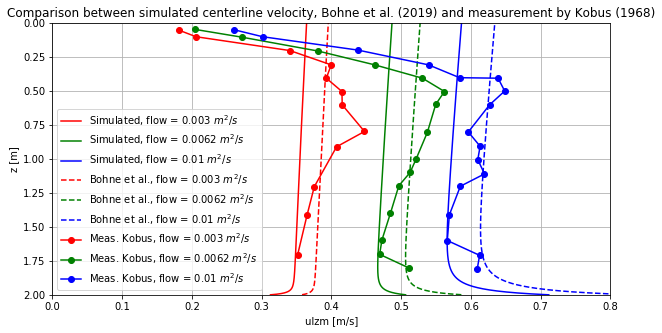

In [177]:
path = 'C:\\Users\ipj\OneDrive - Van Oord\Coronabackup\Graduation\Data&Code\Real_Data\Bohne_compare'

file = os.path.join(path, 'Bohne1.txt')
file2 = os.path.join(path, 'Bohne2.txt')
file3 = os.path.join(path, 'Bohne3.txt')
col_names=['ulzm', 'z']

dfb1 = pd.read_csv(file, delim_whitespace=True, header=None, names=col_names)
dfb1.z = dfb1.z*-1
dfb1.z = dfb1.z.values[::-1]


dfb2 = pd.read_csv(file2, delim_whitespace=True, header=None, names=col_names)
dfb2.z = dfb2.z*-1
dfb2.z = dfb2.z.values[::-1]

dfb3 = pd.read_csv(file3, delim_whitespace=True, header=None, names=col_names)
dfb3.z = dfb3.z*-1
dfb3.z = dfb3.z.values[::-1]


file = os.path.join(path, 'Kobus1.txt')
file2 = os.path.join(path, 'Kobus2.txt')
file3 = os.path.join(path, 'Kobus3.txt')
col_names=['ulzm', 'z']

kobus1 = pd.read_csv(file, delim_whitespace=True, header=None, names=col_names)
kobus1.z = kobus1.z*-1
kobus1.z = kobus1.z.values[::-1]

kobus2 = pd.read_csv(file2, delim_whitespace=True, header=None, names=col_names)
kobus2.z = kobus2.z*-1
kobus2.z = kobus2.z.values[::-1]

kobus3 = pd.read_csv(file3, delim_whitespace=True, header=None, names=col_names)
kobus3.z = kobus3.z*-1
kobus3.z = kobus3.z.values[::-1]

fig,ax = plt.subplots(figsize=(10,5))

colors = ['r', 'g', 'b']

for q,s,c in zip([q1,q2,q3], sims, colors) :
    ax.plot(q[:,0],z[::-1],color = c, label='Simulated, flow = {} $m^2/s$'.format(s.airflow))


for df,s, c in zip([dfb1, dfb2, dfb3],sims, colors):
    ax.plot(df.ulzm, dfb1.z[::-1],'--', color= c, label = 'Bohne et al., flow = {} $m^2/s$'.format(s.airflow))


for kobus, s, c in zip([kobus1, kobus2, kobus3], sims, colors):
    ax.plot(kobus.ulzm, kobus.z[::-1], marker='o', color=c, label='Meas. Kobus, flow = {} $m^2/s$'.format(s.airflow))

ax.grid()
ax.set_ylim(z.min(), z.max())
ax.set_xlim(0, 0.8)
ax.legend()
ax.invert_yaxis()
ax.set_title("Comparison between simulated centerline velocity, Bohne et al. (2019) and measurement by Kobus (1968)")
ax.set_xlabel('ulzm [m/s]')
ax.set_ylabel('z [m]')



plt.show()

savepath = 'C:\\Users\ipj\OneDrive - Van Oord\Figs_backup\Full simulations\Dump'
filename = 'Bohne_comparison.png'
filepath = os.path.join(savepath, filename)

fig.tight_layout()

fig.savefig(filepath, dpi=300)

(75,)